In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
import pandas as pd

data = pd.read_csv('/content/gdrive/MyDrive/balanced_all_data_set.csv')
data

,Category,Unnamed: 0,Topic Title,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies
0,distributed,0,About the distributed category,[],(Replace this first paragraph with a brief des...,"['Hi, smth, this is my (maybe almost) first co...","Dec 30, 2018 11:01 pm",0,701,1
1,distributed,1,Memory leak when using RPC for pipeline parall...,['distributed-rpc'],"Hi, when I use torch.distributed.rpc to implem...",['This looks interesting!\nI think firs you ne...,"Jul 20, 2021 5:39 am",0,75,11
2,distributed,2,Distributed Data Parallel example - “process 0...,[],I’m running Distributed Data Parallel example ...,[],0,0,0,0
3,distributed,3,How to use 8GPUs as 1,[],Hi I’m trying to do a learning a certain way a...,[],0,0,0,0
4,distributed,4,Disabling all reduce in Distributed Data Parallel,[],"Hello, I’m trying to setup distributed model t...",['\nIs it possible to disable this functionali...,"Jul 21, 2021 9:09 am",0,25,3
...,...,...,...,...,...,...,...,...,...,...
27742,uncategorized,9995,Pytorch conv_transpose2d and TF conv2d_trasnpose,NaN,I am converting a TF weight to Pytorch.\nI cop...,"[""Didn’t this one work?\n inp = F.pad(inp, [1...","Jul 5, 2018 6:51 am",0,708,1
27743,uncategorized,9996,(Cross entropy loss) accuracy on siamese net a...,NaN,I have a siamese network which I am training o...,['Can you please put your code here? Then we c...,"May 19, 2020 3:31 am",1,93,1
27744,uncategorized,9997,Torch.stack yielding wrong dimensions,NaN,"I am quite new to pytorch, and I am trying to ...","['Since you are passing two values to self.c, ...","May 18, 2020 3:47 pm",0,123,2
27745,uncategorized,9998,Set elements of a matrix prior to a specific i...,NaN,"Hi\nI have an index vector like:\nidx_v = [1,...",['This code should work:\nidx_v = torch.tensor...,"May 18, 2020 4:23 am",1,115,2


In [ ]:
data.columns

Index(['Category', 'Unnamed: 0', 'Topic Title', 'Tags', 'Leading Post',
       'Post Replies', 'Created_at', 'Likes', 'Views', 'Replies'],
      dtype='object')

In [ ]:
data.drop(columns= ['Unnamed: 0', 'Tags'], inplace=True)

In [ ]:
data.head()

,Category,Topic Title,Leading Post,Post Replies,Created_at,Likes,Views,Replies
0,distributed,About the distributed category,(Replace this first paragraph with a brief des...,"['Hi, smth, this is my (maybe almost) first co...","Dec 30, 2018 11:01 pm",0,701,1
1,distributed,Memory leak when using RPC for pipeline parall...,"Hi, when I use torch.distributed.rpc to implem...",['This looks interesting!\nI think firs you ne...,"Jul 20, 2021 5:39 am",0,75,11
2,distributed,Distributed Data Parallel example - “process 0...,I’m running Distributed Data Parallel example ...,[],0,0,0,0
3,distributed,How to use 8GPUs as 1,Hi I’m trying to do a learning a certain way a...,[],0,0,0,0
4,distributed,Disabling all reduce in Distributed Data Parallel,"Hello, I’m trying to setup distributed model t...",['\nIs it possible to disable this functionali...,"Jul 21, 2021 9:09 am",0,25,3


In [ ]:
#Explore the data===========================================================
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27747 entries, 0 to 27746
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Category      27747 non-null  object
 1   Topic Title   27747 non-null  object
 2   Leading Post  27743 non-null  object
 3   Post Replies  27747 non-null  object
 4   Created_at    27747 non-null  object
 5   Likes         27747 non-null  int64 
 6   Views         27747 non-null  object
 7   Replies       27747 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


In [ ]:
df['post'] = df['Topic Title'] + ' ' + df['Leading Post'] + ' ' + df['Post Replies']

In [ ]:
df['post'].head()

0    About the distributed category (Replace this f...
1    Memory leak when using RPC for pipeline parall...
2    Distributed Data Parallel example - “process 0...
3    How to use 8GPUs as 1 Hi I’m trying to do a le...
4    Disabling all reduce in Distributed Data Paral...
Name: post, dtype: object

In [ ]:
df['post'][1]
df = df[df['post'].notnull()]
df['post'].apply(lambda x: len(x.split(' '))).sum()

15512636

In [ ]:
df['Category'].unique()

array(['distributed', 'autograd', 'C++', 'deployment', 'jit',
       'quantization', 'glow', 'nlp', 'Mobile', 'reinforcement-learning',
       'Memory Format', 'audio', 'mixed-precision', 'Site Feedback',
       'vision', 'uncategorized'], dtype=object)

Text(0, 0.5, 'no of posts')

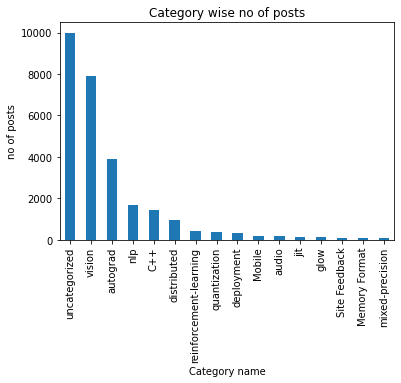

In [ ]:
my_categories = ['distributed', 'autograd', 'C++', 'deployment', 'jit',
       'quantization', 'glow', 'nlp', 'Mobile', 'reinforcement-learning',
       'Memory Format', 'audio', 'mixed-precision', 'Site Feedback',
       'vision', 'uncategorized']


df['Category'].value_counts().plot.bar()
plt.title('Category wise no of posts')
plt.xlabel('Category name')
plt.ylabel('no of posts')

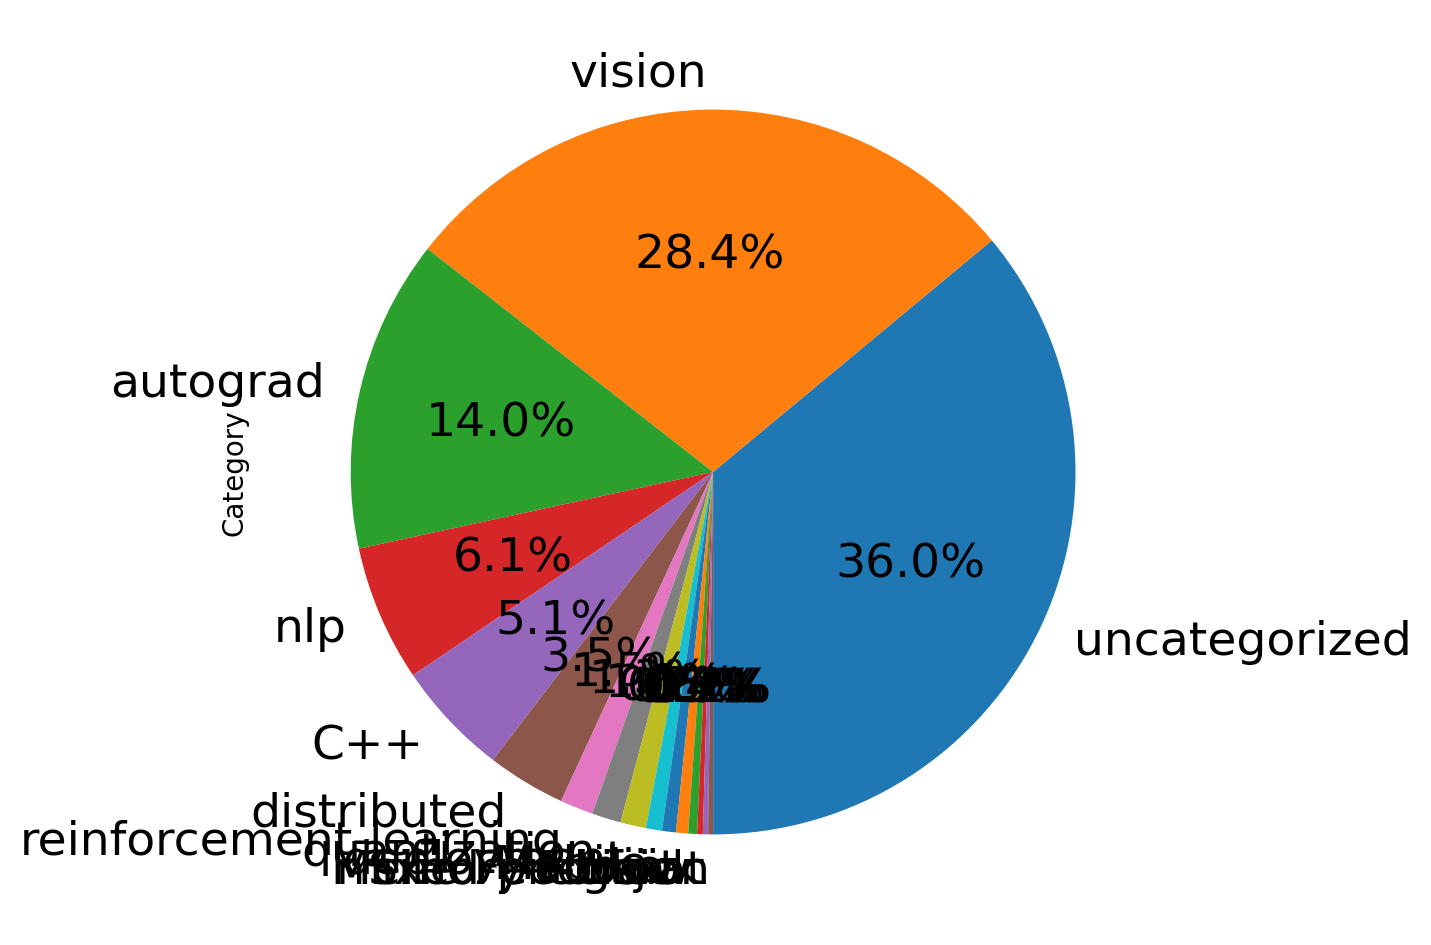

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=200)
ax = plt.subplot(111)

df['Category'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=270, fontsize=17)

In [ ]:
def print_plot(index):
    example = df[df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
print_plot(10)

Should we split batch_size according to ngpu_per_node when DistributedDataparallel Assume we have two nodes: node-A and node-B, each has 4gpus(i.e. ngpu_per_node=4). We set args.batch_size = 256 on each node, means that we want each node process 256 images in each forward.
(1) If we use DistributedDataparallel with 1gpu-per-process mode, shall we manually divide the batchsize by ngpu_per_node in torch.utils.data.DataLoader : torch.utils.data.DataLoader(batch_size = args.batch_size / 4)(the way used in pytorch-imagenet-official-example 53). In my original opinion, I think DistributedSampler can handle such thing, because we have passed world_size and rank to DistributedSampler. . If I was wrong, please point it out, thanks!
(2) If dividing the batchsize by ngpu_per_node is a correct way, I wonder what will happen if we do not that.


Does it means in each node, 4*batch_size images are processed per forward-process?


Will 4*len(dataset)  images are processed in one epoch, or the forward

In [ ]:
#Text Pre-processing========================================================
test_df = df.copy()

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    return text

In [ ]:
test_df['post'] = test_df['post'].apply(lambda x: clean_text(str(x)))

In [ ]:
def test_print_plot(index):
    example = test_df[test_df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(10)

should we split batch_size according to ngpu_per_node when distributeddataparallel assume we have two nodes: node-a and node-b  each has 4gpus i.e. ngpu_per_node=4 . we set args.batch_size = 256 on each node  means that we want each node process 256 images in each forward.
 1  if we use distributeddataparallel with 1gpu-per-process mode  shall we manually divide the batchsize by ngpu_per_node in torch.utils.data.dataloader : torch.utils.data.dataloader batch_size = args.batch_size   4  the way used in pytorch-imagenet-official-example 53 . in my original opinion  i think distributedsampler can handle such thing  because we have passed world_size and rank to distributedsampler. . if i was wrong  please point it out  thanks!
 2  if dividing the batchsize by ngpu_per_node is a correct way  i wonder what will happen if we do not that.


does it means in each node  4*batch_size images are processed per forward-process?


will 4*len dataset   images are processed in one epoch  or the forward

In [ ]:
test_df['post'].apply(lambda x: len(x.split(' '))).sum()

19692305

In [ ]:
19692305 - 15512636

4179669

In [ ]:
#MODELING THE DATA===========================================================

X = test_df['post']
y = test_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
X_train

24119    script error: module has no attribute _modules...
23683    using mse loss on batch i m trying to use mse ...
21688    best input size of a the first layer 1d cnn i ...
5897     convert tensor into an array hi \ni m new in p...
9654     query : loop for batch per epoch hello all \ni...
                               ...                        
21578    training multivariate normal covariance matrix...
5391     how portable are torch::save   load   models i...
860      get local size in distributed training anyway ...
15796    using places365 with pytorch i m trying to loa...
23657    can we use .cpu   to save memory on gpu? i try...
Name: post, Length: 19420, dtype: object

In [ ]:
y_train

24119    uncategorized
23683    uncategorized
21688    uncategorized
5897               C++
9654             audio
             ...      
21578    uncategorized
5391               C++
860        distributed
15796           vision
23657    uncategorized
Name: Category, Length: 19420, dtype: object

In [ ]:
#Naive Bayes Classifier for Multinomials Models==============================
#CountVectorizer + TF-IDF Transformer + MultinomialNB
# TF-IDF = Term Frequency — Inverse Document Frequency

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1311 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.4046617806079539
                        precision    recall  f1-score   support

           distributed       0.00      0.00      0.00       407
              autograd       0.00      0.00      0.00        23
                   C++       0.00      0.00      0.00        55
            deployment       0.00      0.00      0.00        16
                   jit       0.00      0.00      0.00        56
          quantization       0.67      0.00      0.00      1177
                  glow       0.00      0.00      0.00       105
                   nlp       0.00      0.00      0.00       275
                Mobile       0.00      0.00      0.00        24
reinforcement-learning       0.00      0.00      0.00        50
         Memory Format       0.00      0.00      0.00        15
                 audio       0.00      0.00      0.00       523
       mixed-precision       0.00      0.00      0.00       102
         Site Feedback       0.00      0.00      0.00       125
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#LINEAR SUPPORT VECTOR MACHINE================================================
#CountVectorizer + TF-IDFTransformer + SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1321 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.6080740117746005
                        precision    recall  f1-score   support

           distributed       0.69      0.77      0.73       407
              autograd       0.00      0.00      0.00        23
                   C++       0.80      0.51      0.62        55
            deployment       0.00      0.00      0.00        16
                   jit       0.71      0.18      0.29        56
          quantization       0.59      0.77      0.67      1177
                  glow       0.70      0.07      0.12       105
                   nlp       0.64      0.70      0.67       275
                Mobile       0.94      0.71      0.81        24
reinforcement-learning       0.50      0.10      0.17        50
         Memory Format       0.00      0.00      0.00        15
                 audio       0.70      0.50      0.59       523
       mixed-precision       0.79      0.87      0.83       102
         Site Feedback       0.82      0.44      0.57       125
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Logistic Regression==========================================================
#CountVectorizer + TF-IDFTransformer + Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1331 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.5602547158476511
                        precision    recall  f1-score   support

           distributed       0.71      0.69      0.70       407
              autograd       0.15      0.09      0.11        23
                   C++       0.79      0.55      0.65        55
            deployment       0.00      0.00      0.00        16
                   jit       0.68      0.46      0.55        56
          quantization       0.59      0.60      0.59      1177
                  glow       0.30      0.20      0.24       105
                   nlp       0.64      0.55      0.59       275
                Mobile       0.90      0.75      0.82        24
reinforcement-learning       0.48      0.20      0.28        50
         Memory Format       0.50      0.47      0.48        15
                 audio       0.60      0.49      0.54       523
       mixed-precision       0.82      0.81      0.82       102
         Site Feedback       0.81      0.49      0.61       125
           

In [ ]:
#Decision Tree================================================================
#CountVectorizer + TF-IDFTransformer + DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

dtree = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=0)),
               ])
dtree.fit(X_train, y_train)

y_pred = dtree.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1341 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.4614922503904842
                        precision    recall  f1-score   support

           distributed       0.50      0.51      0.50       407
              autograd       0.00      0.00      0.00        23
                   C++       0.60      0.56      0.58        55
            deployment       0.00      0.00      0.00        16
                   jit       0.50      0.27      0.35        56
          quantization       0.50      0.51      0.50      1177
                  glow       0.06      0.04      0.05       105
                   nlp       0.57      0.48      0.52       275
                Mobile       0.78      0.75      0.77        24
reinforcement-learning       0.23      0.12      0.16        50
         Memory Format       0.06      0.07      0.06        15
                 audio       0.38      0.36      0.37       523
       mixed-precision       0.72      0.70      0.71       102
         Site Feedback       0.44      0.28      0.34       125
           

In [ ]:
#RESULT========================================================================
#Results of the previously trained models

import pandas as pd

results = pd.DataFrame({'Model': ['Naive Bayes MultinomialNB', 'Linear SVM', 'Logistic Regression', 'Decision Tree'],
                         'Accuracy': [res1311, res1321, res1331, res1341]})
results.set_index('Model')
results.sort_values(by='Accuracy')

,Model,Accuracy
0,Naive Bayes MultinomialNB,0.404662
3,Decision Tree,0.461492
2,Logistic Regression,0.560255
1,Linear SVM,0.608074


In [ ]:
#Cross Validation with linear SVM=============================================

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
cv_res_sgd = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd = np.mean(cv_res_sgd)

In [ ]:
print(mean_cv_res_sgd)

0.6159114315139032


In [ ]:
# Strategy 2 ================================================================
# Remove stop words (+ what was done in Strategy 1)

In [ ]:
test_df2 = test_df.copy()

In [ ]:
import nltk
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
test_df2['post'] = test_df2['post'].apply(clean_text)

In [ ]:
def test_print_plot(index):
    example = test_df2[test_df2.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(10)

split batch_size according ngpu_per_node distributeddataparallel assume two nodes: node-a node-b 4gpus i.e. ngpu_per_node=4 . set args.batch_size = 256 node means want node process 256 images forward. 1 use distributeddataparallel 1gpu-per-process mode shall manually divide batchsize ngpu_per_node torch.utils.data.dataloader : torch.utils.data.dataloader batch_size = args.batch_size 4 way used pytorch-imagenet-official-example 53 . original opinion think distributedsampler handle thing passed world_size rank distributedsampler. . wrong please point thanks! 2 dividing batchsize ngpu_per_node correct way wonder happen that. means node 4*batch_size images processed per forward-process? 4*len dataset images processed one epoch forward frequency four times less usual i.e. total number images proceeded per epoch keep ? \n\n\n hhxx:\n\n 2 dividing batchsize ngpu_per_node correct way wonder happen that.\n\ndoes means node 4*batch_size images processed per forward-process?\nwill 4*len dataset i

In [ ]:
#Modeling the data=============================================================
X = test_df2.post
y = test_df2.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
X_train

24119    script error: module attribute _modules runtim...
23683    using mse loss batch trying use mse loss batch...
21688    best input size first layer 1d cnn trying buil...
5897     convert tensor array hi new pytorch would like...
9654     query : loop batch per epoch hello query regar...
                               ...                        
21578    training multivariate normal covariance matrix...
5391     portable torch::save load models c++? portable...
860      get local size distributed training anyway get...
15796    using places365 pytorch trying load vgg16 vers...
23657    use .cpu save memory gpu? try save memory gpu ...
Name: post, Length: 19420, dtype: object

In [ ]:
y_train

24119    uncategorized
23683    uncategorized
21688    uncategorized
5897               C++
9654             audio
             ...      
21578    uncategorized
5391               C++
860        distributed
15796           vision
23657    uncategorized
Name: Category, Length: 19420, dtype: object

In [ ]:
#Naive Bayes Classifier for Multinomial Models
#CountVectorizer + TF-IDFTransformer + MultinomialNB


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2311 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.41823861588369576
                        precision    recall  f1-score   support

           distributed       0.00      0.00      0.00       407
              autograd       0.00      0.00      0.00        23
                   C++       0.00      0.00      0.00        55
            deployment       0.00      0.00      0.00        16
                   jit       0.00      0.00      0.00        56
          quantization       0.80      0.01      0.01      1177
                  glow       0.00      0.00      0.00       105
                   nlp       0.00      0.00      0.00       275
                Mobile       0.00      0.00      0.00        24
reinforcement-learning       0.00      0.00      0.00        50
         Memory Format       0.00      0.00      0.00        15
                 audio       0.00      0.00      0.00       523
       mixed-precision       0.00      0.00      0.00       102
         Site Feedback       0.00      0.00      0.00       125
          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Linear Support Vector Machine
#CountVectorizer + TF-IDFTransformer + SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2321 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.6095157995914935
                        precision    recall  f1-score   support

           distributed       0.68      0.77      0.73       407
              autograd       0.00      0.00      0.00        23
                   C++       0.83      0.53      0.64        55
            deployment       0.00      0.00      0.00        16
                   jit       0.73      0.20      0.31        56
          quantization       0.59      0.77      0.67      1177
                  glow       0.64      0.07      0.12       105
                   nlp       0.64      0.69      0.66       275
                Mobile       0.94      0.67      0.78        24
reinforcement-learning       0.58      0.14      0.23        50
         Memory Format       0.00      0.00      0.00        15
                 audio       0.70      0.50      0.58       523
       mixed-precision       0.80      0.87      0.84       102
         Site Feedback       0.82      0.43      0.57       125
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Logistic Regression
#CountVectorizer + TF-IDFTransformer + Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2331 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.5626576955424727
                        precision    recall  f1-score   support

           distributed       0.74      0.66      0.70       407
              autograd       0.25      0.09      0.13        23
                   C++       0.77      0.55      0.64        55
            deployment       0.17      0.06      0.09        16
                   jit       0.56      0.62      0.59        56
          quantization       0.64      0.55      0.59      1177
                  glow       0.34      0.15      0.21       105
                   nlp       0.60      0.55      0.57       275
                Mobile       0.68      0.88      0.76        24
reinforcement-learning       0.47      0.58      0.52        50
         Memory Format       0.50      0.47      0.48        15
                 audio       0.61      0.52      0.56       523
       mixed-precision       0.86      0.82      0.84       102
         Site Feedback       0.72      0.51      0.60       125
           

In [ ]:
#Decision Tree
#CountVectorizer + TF-IDFTransformer + DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

dtree = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=0)),
               ])
dtree.fit(X_train, y_train)

y_pred = dtree.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2341 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.4693019343986543
                        precision    recall  f1-score   support

           distributed       0.56      0.56      0.56       407
              autograd       0.00      0.00      0.00        23
                   C++       0.54      0.62      0.58        55
            deployment       0.09      0.06      0.07        16
                   jit       0.33      0.20      0.25        56
          quantization       0.51      0.51      0.51      1177
                  glow       0.04      0.03      0.03       105
                   nlp       0.51      0.50      0.50       275
                Mobile       0.77      0.71      0.74        24
reinforcement-learning       0.17      0.10      0.12        50
         Memory Format       0.11      0.07      0.08        15
                 audio       0.40      0.37      0.38       523
       mixed-precision       0.68      0.68      0.68       102
         Site Feedback       0.39      0.30      0.34       125
           

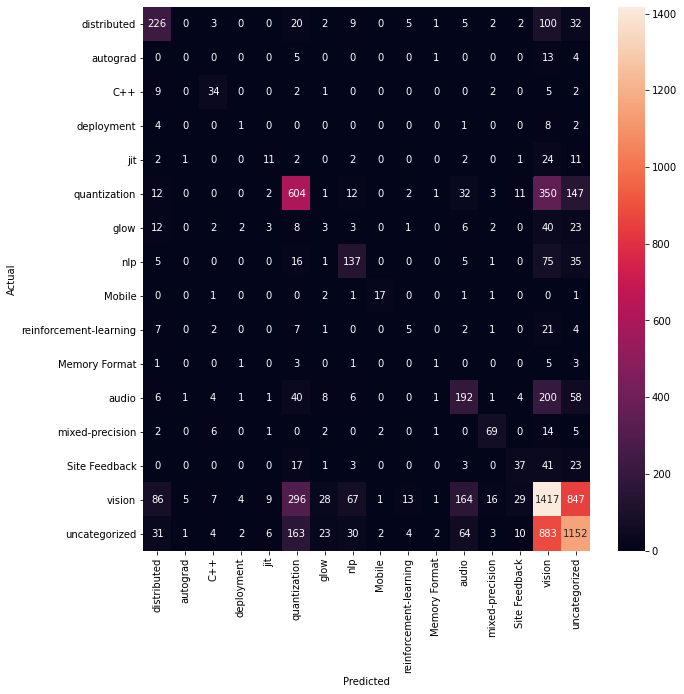

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=my_categories, yticklabels=my_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#Results
#Results of the previously trained models
import pandas as pd

results = pd.DataFrame({'Model': ['Naive Bayes MultinomialNB', 'Linear SVM', 'Logistic Regression', 'Decision Tree'],
                         'Accuracy': [res2311, res2321, res2331, res2341]})
results.set_index('Model')
results.sort_values(by='Accuracy')

,Model,Accuracy
0,Naive Bayes MultinomialNB,0.418239
3,Decision Tree,0.469302
2,Logistic Regression,0.562658
1,Linear SVM,0.609516


In [ ]:
#Cross Validation with linear SVM

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
cv_res_sgd2 = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd2 = np.mean(cv_res_sgd2)

In [ ]:
print(mean_cv_res_sgd2)

0.6139546858908342


In [ ]:
#Strategy 3 ==================================================================
#text.replace(r'\n', ' ') (+ what was done in Strategy 2)

In [ ]:
test_df3 = test_df2.copy()

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace(r'\n', ' ')
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
test_df3['post'] = test_df3['post'].apply(clean_text)

In [ ]:
def test_print_plot(index):
    example = test_df3[test_df3.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(10)

split batch_size according ngpu_per_node distributeddataparallel assume two nodes: node-a node-b 4gpus i.e. ngpu_per_node=4 . set args.batch_size = 256 node means want node process 256 images forward. 1 use distributeddataparallel 1gpu-per-process mode shall manually divide batchsize ngpu_per_node torch.utils.data.dataloader : torch.utils.data.dataloader batch_size = args.batch_size 4 way used pytorch-imagenet-official-example 53 . original opinion think distributedsampler handle thing passed world_size rank distributedsampler. . wrong please point thanks! 2 dividing batchsize ngpu_per_node correct way wonder happen that. means node 4*batch_size images processed per forward-process? 4*len dataset images processed one epoch forward frequency four times less usual i.e. total number images proceeded per epoch keep ? hhxx: 2 dividing batchsize ngpu_per_node correct way wonder happen that. means node 4*batch_size images processed per forward-process? 4*len dataset images processed one epoch

In [ ]:
#Cross Validation with linear SVM
X = test_df3.post
y = test_df3.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
cv_res_sgd3 = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd3 = np.mean(cv_res_sgd3)

In [ ]:
print(mean_cv_res_sgd3)

0.6138516992790937


In [ ]:
#Random Forest===============================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=500, max_depth=500, random_state=0)),
               ])

cv_res_rf = cross_val_score(rf, X_train, y_train, cv=10)
mean_cv_res_rf = np.mean(cv_res_rf)

In [ ]:
print(mean_cv_res_rf)#max_depth = 10, n_estimators=300

0.5705458290422245


In [ ]:
print(mean_cv_res_rf)# max_depth = 100, n_estimators=300

0.5705458290422245


In [ ]:
print(mean_cv_res_rf)# max_depth = 500, n_estimators=300

0.5705458290422245


In [ ]:
##### BEST #####
print(mean_cv_res_rf)# max_depth = 500, n_estimators=400 
##### BEST #####

0.5705458290422245


In [ ]:
print(mean_cv_res_rf)# max_depth = 1000, n_estimators=400

0.5705458290422245


In [ ]:
print(mean_cv_res_rf)# max_depth = 500, n_estimators=500

0.5705458290422245


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

rf = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200, max_depth=100, random_state=0)),
               ])

cv_res_rf_tfidf = cross_val_score(rf, X_train, y_train, cv=10)
mean_cv_res_rf_tfidf = np.mean(cv_res_rf_tfidf)

In [ ]:
mean_cv_res_rf_tfidf# max_depth = 500, n_estimators=500

0.5579299691040165

In [ ]:
mean_cv_res_rf_tfidf # n_estimators=200, max_depth=100

0.5579299691040165

In [ ]:
#Using TF-IDF as a vectorizer and transformer is slighly better than using CountVectorizer as a Vectorizer.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None)),
               ])
cv_res_sgd_tfidf = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd_tfidf = np.mean(cv_res_sgd_tfidf)

In [ ]:
mean_cv_res_sgd_tfidf #10 in max_iter

0.6179711637487126

In [ ]:
mean_cv_res_sgd_tfidf# 100 in max_iter

0.6179711637487126

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

xgb = Pipeline(steps=[('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])

cv_res_xgb_tfidf = cross_val_score(xgb, X_train, y_train, cv=10)
mean_cv_res_xgb_tfidf = np.mean(cv_res_xgb_tfidf)

In [ ]:
mean_cv_res_xgb_tfidf

0.6066941297631308

In [ ]:
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
res_xgb = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.599783731827466
                        precision    recall  f1-score   support

           distributed       0.77      0.67      0.72       407
              autograd       0.00      0.00      0.00        23
                   C++       0.80      0.73      0.76        55
            deployment       0.00      0.00      0.00        16
                   jit       0.71      0.36      0.48        56
          quantization       0.66      0.67      0.66      1177
                  glow       0.67      0.08      0.14       105
                   nlp       0.71      0.67      0.69       275
                Mobile       0.90      0.79      0.84        24
reinforcement-learning       0.48      0.22      0.30        50
         Memory Format       0.38      0.33      0.36        15
                 audio       0.70      0.42      0.52       523
       mixed-precision       0.77      0.90      0.83       102
         Site Feedback       0.72      0.43      0.54       125
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


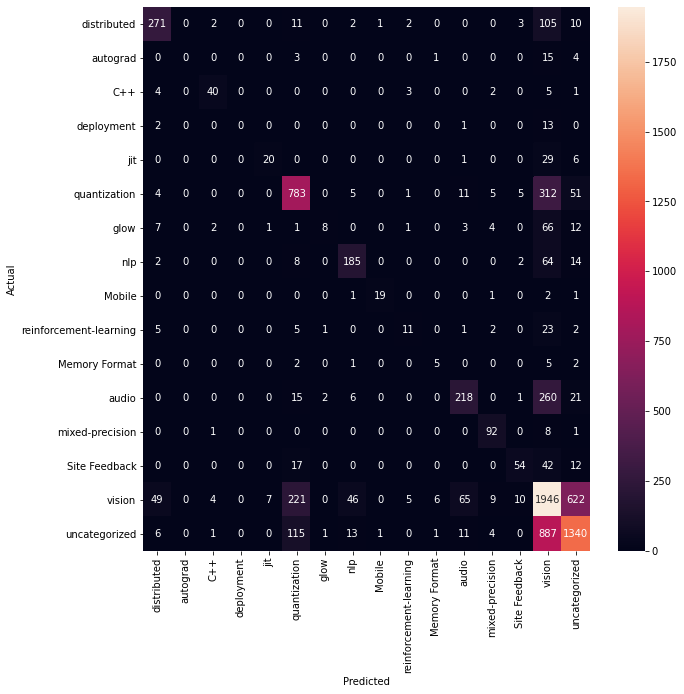

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=my_categories, yticklabels=my_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgbm

tfidf_vec = TfidfVectorizer(dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)
X_data_tfidf = tfidf_vec.fit_transform(test_df3['post'])
X_train_tfidf = tfidf_vec.transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

clf_LGBM = lgbm.LGBMClassifier(objective='multiclass', verbose=-1, learning_rate=0.5, max_depth=20, num_leaves=50, n_estimators=120, max_bin=2000,)
clf_LGBM.fit(X_train_tfidf, y_train, verbose=-1)
predicted_LGBM = clf_LGBM.predict(X_test_tfidf)

In [ ]:
cv_res_lgbm_tfidf = cross_val_score(clf_LGBM, X_train_tfidf, y_train, cv=10)
mean_cv_res_lgbm_tfidf = np.mean(cv_res_lgbm_tfidf)

In [ ]:
mean_cv_res_lgbm_tfidf

0.2818228630278064

In [ ]:
print('accuracy %s' % accuracy_score(predicted_LGBM, y_test))
res_lgbm = accuracy_score(predicted_LGBM, y_test)
print(classification_report(y_test, predicted_LGBM,target_names=my_categories))

accuracy 0.2099002763426649
                        precision    recall  f1-score   support

           distributed       0.00      0.00      0.00       407
              autograd       0.00      0.00      0.00        23
                   C++       0.00      0.00      0.00        55
            deployment       0.00      0.00      0.00        16
                   jit       0.00      0.00      0.00        56
          quantization       0.15      0.62      0.24      1177
                  glow       0.00      0.00      0.00       105
                   nlp       0.00      0.00      0.00       275
                Mobile       0.00      0.00      0.00        24
reinforcement-learning       0.00      0.00      0.00        50
         Memory Format       0.00      0.00      0.00        15
                 audio       0.50      0.00      0.00       523
       mixed-precision       0.00      0.00      0.00       102
         Site Feedback       0.00      0.00      0.00       125
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


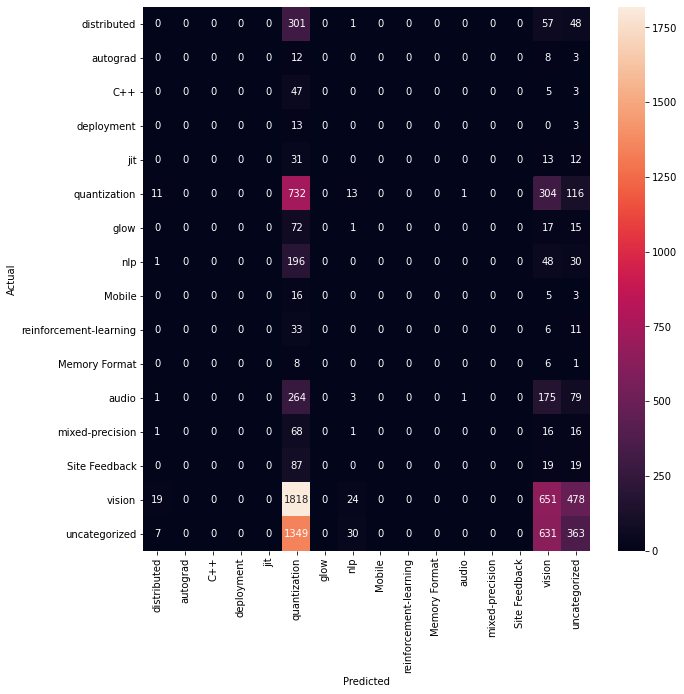

In [ ]:
conf_mat = confusion_matrix(y_test, predicted_LGBM)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=my_categories, yticklabels=my_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()